# Experiment 4: Teacher-Student Pseudo-Labeling for Domain Adaptation

This experiment implements a teacher-student pseudo-labeling approach to improve generalization to field images using unlabeled field data.

## Overview

1. **Teacher Model**: Trained on PlantVillage only (using baseline augmentation from Experiment 3)
2. **Pseudo-Labeling**: Teacher generates high-confidence predictions on unlabeled field images
3. **Student Model**: Trained on combined PlantVillage + pseudo-labeled field data
4. **Evaluation**: Compare teacher vs student on both PV test and Field test sets

## Key Steps

- Step 0: Freeze evaluation protocol (same Field Test Set from Experiment 3)
- Step 1: Train teacher model on PlantVillage
- Step 2: Generate pseudo-labels on unlabeled field images (confidence ≥ 0.90)
- Step 3: Build combined training set (70% PV / 30% pseudo-field)
- Step 4: Train student model on combined dataset
- Step 5: Evaluate and report metrics


## Imports and Setup


In [3]:
# Imports and Setup
import os
import time
import copy
from pathlib import Path
from collections import Counter, defaultdict
import json
import csv

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset
from torch.amp import autocast, GradScaler

from PIL import Image
import torchvision.transforms as T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import timm
from sklearn.metrics import f1_score, classification_report, confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Mixed precision support
USE_AMP = torch.cuda.is_available() and hasattr(torch.cuda, 'amp')
print(f"Mixed Precision (AMP): {'Enabled' if USE_AMP else 'Disabled'}")

# Paths
current_dir = Path(os.getcwd())

if current_dir.name == "experiment_4":
    BASE_DIR = current_dir.parent
else:
    BASE_DIR = current_dir

METADATA_DIR = BASE_DIR / "metadata"
LABEL_MAPPING_PATH = METADATA_DIR / "label_mapping.json"
DATASET_INDEX_PATH = METADATA_DIR / "dataset_index.json"
DATA_DIR = BASE_DIR / "data"
FIELDPLANT_DIR = DATA_DIR / "FieldPlant_reformatted"

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

EXPERIMENT_DIR = BASE_DIR / "experiment_4"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Current working directory: {current_dir}")
print(f"Base directory: {BASE_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Experiment directory: {EXPERIMENT_DIR}")


C:\Users\Kero\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Mixed Precision (AMP): Enabled
Current working directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_4
Base directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION
Models directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\models
Experiment directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_4


## Step 0: Load Metadata and Create Class Mappings


In [4]:
# Load main dataset metadata
with open(LABEL_MAPPING_PATH, "r") as f:
    label_mapping = json.load(f)

with open(DATASET_INDEX_PATH, "r") as f:
    dataset_index = json.load(f)

# Create mappings
id_to_label = {c["id"]: c["canonical_label"] for c in label_mapping["classes"]}
label_to_id = {v: k for k, v in id_to_label.items()}

num_classes = len(label_mapping["classes"])
print(f"Main dataset: {num_classes} classes")
print(f"Total samples in dataset_index: {len(dataset_index)}")

# FieldPlant to canonical label mapping (same as Experiment 3)
fieldplant_to_canonical = {
    "Corn___Gray_leaf_spot": "corn_cercospora_leaf_spot_gray_leaf_spot",
    "Corn___rust_leaf": "corn_common_rust",
    "Corn___leaf_blight": "corn_northern_leaf_blight",
    "Corn___healthy": "corn_healthy",
    "Tomato___healthy": "tomato_healthy",
    "Tomato___leaf_mosaic_virus": "tomato_tomato_mosaic_virus",
    "Tomato___leaf_yellow_virus": "tomato_tomato_yellow_leaf_curl_virus",
}

# Find intersection classes (same as Experiment 3)
fieldplant_classes = set(fieldplant_to_canonical.values())
pv_classes = set(id_to_label.values())
intersection_classes = fieldplant_classes.intersection(pv_classes)

print(f"\nIntersection classes (PV ∩ FieldPlant): {len(intersection_classes)}")
for cls in sorted(intersection_classes):
    print(f"  - {cls}")


Main dataset: 39 classes
Total samples in dataset_index: 61486

Intersection classes (PV ∩ FieldPlant): 7
  - corn_cercospora_leaf_spot_gray_leaf_spot
  - corn_common_rust
  - corn_healthy
  - corn_northern_leaf_blight
  - tomato_healthy
  - tomato_tomato_mosaic_virus
  - tomato_tomato_yellow_leaf_curl_virus


## Step 0 (continued): Split Field Dataset - Test Set vs Unlabeled Pool

**Important**: Use the same Field Test Set as Experiment 3 (intersection classes only). The remaining field images become the unlabeled pool for pseudo-labeling.


In [5]:
def load_fieldplant_data(data_dir, intersection_classes_only=True):
    """Load FieldPlant dataset entries and map to main dataset class IDs."""
    entries = []
    
    if not data_dir.exists():
        print(f"Warning: {data_dir} does not exist!")
        return entries
    
    for folder in data_dir.iterdir():
        if not folder.is_dir():
            continue
        
        canonical = fieldplant_to_canonical.get(folder.name)
        if canonical is None:
            continue
        
        # Filter to intersection classes only
        if intersection_classes_only and canonical not in intersection_classes:
            continue
        
        if canonical not in label_to_id:
            continue
        
        class_id = label_to_id[canonical]
        
        # Get all images in folder
        image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.JPG"))
        for img_path in image_files:
            entries.append({
                "path": str(img_path),
                "class_id": class_id,
                "dataset": "fieldplant",
                "domain": "field",
                "canonical_label": canonical
            })
    
    return entries

# Load all field data (intersection classes only)
all_field_entries = load_fieldplant_data(FIELDPLANT_DIR, intersection_classes_only=True)
print(f"Total field images (intersection classes): {len(all_field_entries)}")

# Split into test set (same as Experiment 3) and unlabeled pool
# Use 20% for test, 80% for unlabeled pool
np.random.seed(42)  # Same seed as Experiment 3 for reproducibility
indices = np.arange(len(all_field_entries))
np.random.shuffle(indices)

test_size = int(len(all_field_entries) * 0.2)
test_indices = indices[:test_size]
unlabeled_indices = indices[test_size:]

test_entries_field = [all_field_entries[i] for i in test_indices]
unlabeled_entries_field = [all_field_entries[i] for i in unlabeled_indices]

print(f"\nField Test Set (same as Experiment 3): {len(test_entries_field)} samples")
print(f"Field Unlabeled Pool (for pseudo-labeling): {len(unlabeled_entries_field)} samples")

# Show distribution
print("\nTest set distribution:")
test_class_counts = Counter(e["class_id"] for e in test_entries_field)
for class_id, count in sorted(test_class_counts.items()):
    class_name = id_to_label[class_id]
    print(f"  {class_name}: {count}")

print("\nUnlabeled pool distribution:")
unlabeled_class_counts = Counter(e["class_id"] for e in unlabeled_entries_field)
for class_id, count in sorted(unlabeled_class_counts.items()):
    class_name = id_to_label[class_id]
    print(f"  {class_name}: {count}")


Total field images (intersection classes): 4640

Field Test Set (same as Experiment 3): 928 samples
Field Unlabeled Pool (for pseudo-labeling): 3712 samples

Test set distribution:
  corn_cercospora_leaf_spot_gray_leaf_spot: 25
  corn_common_rust: 23
  corn_healthy: 70
  corn_northern_leaf_blight: 652
  tomato_healthy: 106
  tomato_tomato_mosaic_virus: 9
  tomato_tomato_yellow_leaf_curl_virus: 43

Unlabeled pool distribution:
  corn_cercospora_leaf_spot_gray_leaf_spot: 83
  corn_common_rust: 75
  corn_healthy: 234
  corn_northern_leaf_blight: 2652
  tomato_healthy: 452
  tomato_tomato_mosaic_virus: 29
  tomato_tomato_yellow_leaf_curl_virus: 187


## Step 0 (continued): Load PlantVillage Data


In [6]:
# Load PlantVillage training and validation data
train_entries_pv = [e for e in dataset_index if e["split"] == "train"]
val_entries_pv = [e for e in dataset_index if e["split"] == "val"]
test_entries_pv = [e for e in dataset_index if e["split"] == "test"]

print(f"PlantVillage training samples: {len(train_entries_pv)}")
print(f"PlantVillage validation samples: {len(val_entries_pv)}")
print(f"PlantVillage test samples: {len(test_entries_pv)}")


PlantVillage training samples: 49179
PlantVillage validation samples: 6148
PlantVillage test samples: 6159


## Step 0 (continued): Define Transforms


In [7]:
# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224

# Baseline augmentation (for teacher and student on PV data)
transform_baseline_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Lighter augmentation for pseudo-labeled field data (to avoid corrupting noisy labels)
transform_pseudo_field_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Mild color jitter
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Evaluation transform
transform_eval = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

print("✓ Transforms defined")


✓ Transforms defined


## Step 0 (continued): Define Dataset Class


In [8]:
class PlantDataset(Dataset):
    def __init__(self, entries, transform_train=None, transform_eval=None, base_dir=None):
        self.entries = entries
        self.transform_train = transform_train
        self.transform_eval = transform_eval
        self.base_dir = base_dir or BASE_DIR

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        img_path = item["path"]
        class_id = item["class_id"]

        # Resolve path
        if not Path(img_path).is_absolute():
            img_path = self.base_dir / img_path
        else:
            img_path = Path(img_path)

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = Image.new("RGB", (224, 224), (0, 0, 0))
            class_id = 0

        # Apply transform
        if self.transform_train is not None:
            img = self.transform_train(img)
        elif self.transform_eval is not None:
            img = self.transform_eval(img)
        else:
            img = transform_eval(img)

        return img, class_id

print("✓ Dataset class defined")


✓ Dataset class defined


## Step 1: Train Teacher Model on PlantVillage

Train the baseline augmentation model (from Experiment 3) on PlantVillage only. This will be our teacher model.


In [9]:
# Check if teacher model already exists from Experiment 3
teacher_checkpoint_path = MODELS_DIR / "efficientnet_b0_baseline_aug.pt"

if teacher_checkpoint_path.exists():
    print(f"Found existing teacher model from Experiment 3: {teacher_checkpoint_path}")
    print("Loading teacher model...")
    
    checkpoint = torch.load(teacher_checkpoint_path, map_location=DEVICE, weights_only=False)
    teacher_model = timm.create_model(
        checkpoint["model_name"],
        pretrained=False,
        num_classes=num_classes
    )
    teacher_model.load_state_dict(checkpoint["state_dict"])
    teacher_model.to(DEVICE)
    teacher_model.eval()
    
    print(f"✓ Teacher model loaded (best val F1: {checkpoint.get('best_val_f1', 'N/A'):.4f})")
    USE_EXISTING_TEACHER = True
else:
    print("Teacher model not found. Will train new teacher model.")
    USE_EXISTING_TEACHER = False


Found existing teacher model from Experiment 3: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\models\efficientnet_b0_baseline_aug.pt
Loading teacher model...
✓ Teacher model loaded (best val F1: 0.9898)


In [ ]:
# Training functions (same as Experiment 3)
def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None, use_amp=False):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_preds = []
    
    total_batches = len(loader)
    print(f"  Processing {total_batches} batches...", end="", flush=True)

    for batch_idx, (images, targets) in enumerate(loader):
        if (batch_idx + 1) % 100 == 0:
            print(f" {batch_idx + 1}/{total_batches}", end="", flush=True)
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        if use_amp and scaler is not None:
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_targets.append(targets.detach().cpu())
        all_preds.append(preds.detach().cpu())

    if len(all_targets) == 0:
        raise ValueError("Training loader is empty!")
    
    print()  # New line after progress
    all_targets = torch.cat(all_targets).numpy()
    all_preds = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = (all_targets == all_preds).mean()
    epoch_f1 = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

@torch.no_grad()
def evaluate(model, loader, criterion, device, use_amp=False):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_preds = []

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if use_amp:
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, targets)
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_targets.append(targets.detach().cpu())
        all_preds.append(preds.detach().cpu())

    if len(all_targets) == 0:
        return 0.0, 0.0, 0.0, np.array([]), np.array([])
    
    all_targets = torch.cat(all_targets).numpy()
    all_preds = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0.0
    epoch_acc = (all_targets == all_preds).mean() if len(all_targets) > 0 else 0.0
    epoch_f1 = f1_score(all_targets, all_preds, average="macro") if len(all_targets) > 0 else 0.0

    return epoch_loss, epoch_acc, epoch_f1, all_targets, all_preds

print("✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


In [11]:
if not USE_EXISTING_TEACHER:
    # Create datasets and loaders for teacher training
    BATCH_SIZE = 32
    
    train_dataset_teacher = PlantDataset(
        train_entries_pv,
        transform_train=transform_baseline_train,
        transform_eval=None
    )
    val_dataset_teacher = PlantDataset(
        val_entries_pv,
        transform_train=None,
        transform_eval=transform_eval
    )
    
    # Weighted sampler for class balancing
    train_class_counts = Counter(e["class_id"] for e in train_entries_pv)
    max_count = max(train_class_counts.values())
    class_weights = {cid: max_count / cnt for cid, cnt in train_class_counts.items()}
    sample_weights = [class_weights[e["class_id"]] for e in train_entries_pv]
    sampler = WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=len(sample_weights),
        replacement=True
    )
    
    train_loader_teacher = DataLoader(
        train_dataset_teacher,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader_teacher = DataLoader(
        val_dataset_teacher,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    # Train teacher model
    def train_model(model_name="efficientnet_b0", train_loader=None, val_loader=None,
                    max_epochs=20, lr=3e-4, weight_decay=1e-4, device=DEVICE,
                    early_stopping_patience=5, model_suffix=""):
        """Train a model."""
        print(f"\n{'='*70}")
        print(f"TRAINING MODEL: {model_name} ({model_suffix})")
        print(f"{'='*70}")
        
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
        model.to(device)
        
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs)
        criterion = nn.CrossEntropyLoss()
        scaler = GradScaler('cuda') if USE_AMP else None
        
        best_val_f1 = -1.0
        best_state = copy.deepcopy(model.state_dict())
        history = {
            "train_loss": [], "train_acc": [], "train_f1": [],
            "val_loss": [], "val_acc": [], "val_f1": []
        }
        epochs_without_improvement = 0
        
        for epoch in range(1, max_epochs + 1):
            start_time = time.time()
            train_loss, train_acc, train_f1 = train_one_epoch(
                model, train_loader, criterion, optimizer, device, scaler, USE_AMP
            )
            val_loss, val_acc, val_f1, _, _ = evaluate(
                model, val_loader, criterion, device, USE_AMP
            )
            scheduler.step()
            
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["train_f1"].append(train_f1)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_f1"].append(val_f1)
            
            elapsed = time.time() - start_time
            print(f"Epoch {epoch:02d}/{max_epochs} ({elapsed:.1f}s)")
            print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
            print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
            
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_state = copy.deepcopy(model.state_dict())
                epochs_without_improvement = 0
                print(f"  -> New best! Val F1: {best_val_f1:.4f}")
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= early_stopping_patience:
                    print(f"  -> Early stopping after {epoch} epochs")
                    break
        
        model.load_state_dict(best_state)
        ckpt_path = MODELS_DIR / f"{model_name}_{model_suffix}.pt"
        torch.save({
            "model_name": model_name,
            "state_dict": model.state_dict(),
            "num_classes": num_classes,
            "best_val_f1": best_val_f1,
            "history": history,
            "model_suffix": model_suffix
        }, ckpt_path)
        print(f"\nSaved checkpoint to: {ckpt_path}")
        return model, history, best_val_f1
    
    teacher_model, history_teacher, best_val_f1_teacher = train_model(
        model_name="efficientnet_b0",
        train_loader=train_loader_teacher,
        val_loader=val_loader_teacher,
        max_epochs=20,
        lr=3e-4,
        weight_decay=1e-4,
        device=DEVICE,
        early_stopping_patience=5,
        model_suffix="teacher"
    )
    
    # Save teacher model
    teacher_checkpoint_path = MODELS_DIR / "efficientnet_b0_teacher.pt"
    torch.save({
        "model_name": "efficientnet_b0",
        "state_dict": teacher_model.state_dict(),
        "num_classes": num_classes,
        "best_val_f1": best_val_f1_teacher,
        "history": history_teacher,
        "model_suffix": "teacher"
    }, teacher_checkpoint_path)
    print(f"\n✓ Teacher model saved to: {teacher_checkpoint_path}")
else:
    print("Using existing teacher model from Experiment 3")


Using existing teacher model from Experiment 3


## Step 2: Generate Pseudo-Labels on Unlabeled Field Images

Run inference using the teacher model on the unlabeled field pool. Keep only high-confidence predictions (threshold ≥ 0.90, relax to 0.85 if needed, but not below 0.80).


In [12]:
# Create dataset for unlabeled field images
unlabeled_dataset = PlantDataset(
    unlabeled_entries_field,
    transform_train=None,
    transform_eval=transform_eval
)

unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Unlabeled field images: {len(unlabeled_entries_field)}")

# Generate pseudo-labels with confidence scores
teacher_model.eval()
pseudo_labels = []

print("\nGenerating pseudo-labels...")
with torch.no_grad():
    for batch_idx, (images, _) in enumerate(unlabeled_loader):
        images = images.to(DEVICE)
        
        if USE_AMP:
            with autocast(device_type='cuda'):
                outputs = teacher_model(images)
        else:
            outputs = teacher_model(images)
        
        # Get probabilities and predictions
        probs = torch.softmax(outputs, dim=1)
        confidences, predicted_classes = torch.max(probs, dim=1)
        
        # Store results
        for i in range(len(images)):
            idx = batch_idx * 32 + i
            if idx < len(unlabeled_entries_field):
                pseudo_labels.append({
                    "image_path": unlabeled_entries_field[idx]["path"],
                    "pseudo_label": predicted_classes[i].item(),
                    "confidence": confidences[i].item()
                })
        
        if (batch_idx + 1) % 10 == 0:
            print(f"  Processed {batch_idx + 1}/{len(unlabeled_loader)} batches")

print(f"✓ Generated {len(pseudo_labels)} pseudo-labels")

# Filter by confidence threshold
CONFIDENCE_THRESHOLD = 0.90  # Start with 0.90
print(f"\nFiltering pseudo-labels with confidence ≥ {CONFIDENCE_THRESHOLD}...")

high_confidence_pseudo_labels = [
    pl for pl in pseudo_labels if pl["confidence"] >= CONFIDENCE_THRESHOLD
]

print(f"High-confidence pseudo-labels: {len(high_confidence_pseudo_labels)} / {len(pseudo_labels)}")

# If too few samples, relax threshold
if len(high_confidence_pseudo_labels) < 100:  # Minimum threshold
    print(f"Too few samples with threshold {CONFIDENCE_THRESHOLD}. Relaxing to 0.85...")
    CONFIDENCE_THRESHOLD = 0.85
    high_confidence_pseudo_labels = [
        pl for pl in pseudo_labels if pl["confidence"] >= CONFIDENCE_THRESHOLD
    ]
    print(f"High-confidence pseudo-labels: {len(high_confidence_pseudo_labels)} / {len(pseudo_labels)}")
    
    if len(high_confidence_pseudo_labels) < 100:
        print(f"Still too few. Relaxing to 0.80...")
        CONFIDENCE_THRESHOLD = 0.80
        high_confidence_pseudo_labels = [
            pl for pl in pseudo_labels if pl["confidence"] >= CONFIDENCE_THRESHOLD
        ]
        print(f"High-confidence pseudo-labels: {len(high_confidence_pseudo_labels)} / {len(pseudo_labels)}")

# Show distribution by class
pseudo_class_counts = Counter(pl["pseudo_label"] for pl in high_confidence_pseudo_labels)
print(f"\nPseudo-label distribution (confidence ≥ {CONFIDENCE_THRESHOLD}):")
for class_id, count in sorted(pseudo_class_counts.items()):
    class_name = id_to_label[class_id]
    print(f"  {class_name}: {count}")

# Save pseudo-labels to CSV
pseudo_label_csv_path = EXPERIMENT_DIR / "pseudo_labeled_field.csv"
with open(pseudo_label_csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["image_path", "pseudo_label", "confidence"])
    for pl in high_confidence_pseudo_labels:
        writer.writerow([pl["image_path"], pl["pseudo_label"], pl["confidence"]])

print(f"\n✓ Saved pseudo-labels to: {pseudo_label_csv_path}")
print(f"  Confidence threshold used: {CONFIDENCE_THRESHOLD}")
print(f"  Total pseudo-labeled samples: {len(high_confidence_pseudo_labels)}")


Unlabeled field images: 3712

Generating pseudo-labels...
  Processed 10/116 batches
  Processed 20/116 batches
  Processed 30/116 batches
  Processed 40/116 batches
  Processed 50/116 batches
  Processed 60/116 batches
  Processed 70/116 batches
  Processed 80/116 batches
  Processed 90/116 batches
  Processed 100/116 batches
  Processed 110/116 batches
✓ Generated 3712 pseudo-labels

Filtering pseudo-labels with confidence ≥ 0.9...
High-confidence pseudo-labels: 1819 / 3712

Pseudo-label distribution (confidence ≥ 0.9):
  apple_apple_scab: 9
  background_without_leaves: 382
  cherry_healthy: 8
  cherry_powdery_mildew: 1
  corn_cercospora_leaf_spot_gray_leaf_spot: 412
  corn_common_rust: 33
  corn_healthy: 586
  corn_northern_leaf_blight: 175
  grape_healthy: 7
  peach_bacterial_spot: 5
  pepper,_bell_bacterial_spot: 4
  pepper,_bell_healthy: 10
  squash_powdery_mildew: 5
  strawberry_leaf_scorch: 141
  tomato_late_blight: 40
  tomato_leaf_mold: 1

✓ Saved pseudo-labels to: d:\Program

In [13]:
# Create entries for pseudo-labeled field data
pseudo_labeled_entries = []
for pl in high_confidence_pseudo_labels:
    # Find the original entry to get the path structure
    img_path = Path(pl["image_path"])
    pseudo_labeled_entries.append({
        "path": str(img_path),
        "class_id": pl["pseudo_label"],
        "dataset": "fieldplant_pseudo",
        "domain": "field",
        "confidence": pl["confidence"]
    })

print(f"Pseudo-labeled field entries: {len(pseudo_labeled_entries)}")
print(f"PlantVillage training entries: {len(train_entries_pv)}")

# Create datasets
train_dataset_pv = PlantDataset(
    train_entries_pv,
    transform_train=transform_baseline_train,
    transform_eval=None
)

train_dataset_pseudo = PlantDataset(
    pseudo_labeled_entries,
    transform_train=transform_pseudo_field_train,  # Lighter augmentation
    transform_eval=None
)

# Create a custom dataset that combines both PV and pseudo-field
# Maps indices: [0, len(pv)) -> PV, [len(pv), len(pv)+len(pseudo)) -> pseudo
class CombinedDataset(Dataset):
    def __init__(self, pv_dataset, pseudo_dataset):
        self.pv_dataset = pv_dataset
        self.pseudo_dataset = pseudo_dataset
        self.pv_len = len(pv_dataset)
    
    def __len__(self):
        return len(self.pv_dataset) + len(self.pseudo_dataset)
    
    def __getitem__(self, idx):
        if idx < self.pv_len:
            return self.pv_dataset[idx]
        else:
            return self.pseudo_dataset[idx - self.pv_len]

# Create a custom sampler that maintains 70% PV / 30% pseudo-field ratio
class BalancedPVDomainSampler:
    """Sampler that maintains 70% PV / 30% pseudo-field ratio per epoch."""
    def __init__(self, pv_len, pseudo_len, batch_size=32, pv_ratio=0.7):
        self.pv_len = pv_len
        self.pseudo_len = pseudo_len
        self.batch_size = batch_size
        self.pv_ratio = pv_ratio
        
        # Calculate samples per batch
        self.pv_per_batch = int(batch_size * pv_ratio)
        self.pseudo_per_batch = batch_size - self.pv_per_batch
        
        # Total batches needed (use PV dataset size as base)
        self.num_batches = (pv_len + self.pv_per_batch - 1) // self.pv_per_batch
        
    def __iter__(self):
        # Create indices for both datasets
        pv_indices = list(range(self.pv_len))
        pseudo_indices = list(range(self.pseudo_len))
        
        # Shuffle
        np.random.shuffle(pv_indices)
        np.random.shuffle(pseudo_indices)
        
        # Create balanced batches
        pv_idx = 0
        pseudo_idx = 0
        indices = []
        
        for _ in range(self.num_batches):
            batch_indices = []
            
            # Add PV samples
            for _ in range(self.pv_per_batch):
                if pv_idx < len(pv_indices):
                    batch_indices.append(pv_indices[pv_idx])
                    pv_idx += 1
                    if pv_idx >= len(pv_indices):
                        np.random.shuffle(pv_indices)
                        pv_idx = 0
            
            # Add pseudo-field samples
            for _ in range(self.pseudo_per_batch):
                if pseudo_idx < len(pseudo_indices):
                    # Offset by pv_len to map to pseudo dataset
                    batch_indices.append(self.pv_len + pseudo_indices[pseudo_idx])
                    pseudo_idx += 1
                    if pseudo_idx >= len(pseudo_indices):
                        np.random.shuffle(pseudo_indices)
                        pseudo_idx = 0
            
            # Shuffle batch
            np.random.shuffle(batch_indices)
            indices.extend(batch_indices)
        
        return iter(indices)
    
    def __len__(self):
        return self.num_batches

combined_dataset = CombinedDataset(train_dataset_pv, train_dataset_pseudo)
balanced_sampler = BalancedPVDomainSampler(
    len(train_dataset_pv), len(train_dataset_pseudo), 
    batch_size=32, pv_ratio=0.7
)

# Create combined training loader
train_loader_combined = DataLoader(
    combined_dataset,
    batch_size=32,
    sampler=balanced_sampler,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ Combined training set created")
print(f"  PV samples: {len(train_entries_pv)}")
print(f"  Pseudo-labeled field samples: {len(pseudo_labeled_entries)}")
print(f"  Ratio: 70% PV / 30% pseudo-field")
print(f"  Total batches: {len(train_loader_combined)}")


Pseudo-labeled field entries: 1819
PlantVillage training entries: 49179

✓ Combined training set created
  PV samples: 49179
  Pseudo-labeled field samples: 1819
  Ratio: 70% PV / 30% pseudo-field
  Total batches: 70


## Step 4: Train Student Model on Combined Dataset

Initialize student from teacher weights and train on combined PV + pseudo-labeled field data with lower learning rate.


In [14]:
# Create validation loader (PV validation set)
val_dataset_student = PlantDataset(
    val_entries_pv,
    transform_train=None,
    transform_eval=transform_eval
)

val_loader_student = DataLoader(
    val_dataset_student,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Initialize student from teacher weights
print("Initializing student model from teacher weights...")
student_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
student_model.load_state_dict(teacher_model.state_dict())  # Start from teacher
student_model.to(DEVICE)

# Train student with lower learning rate
print("\n" + "="*70)
print("TRAINING STUDENT MODEL")
print("="*70)

optimizer_student = AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-4)  # Lower LR
scheduler_student = CosineAnnealingLR(optimizer_student, T_max=15)
criterion = nn.CrossEntropyLoss()
scaler_student = GradScaler('cuda') if USE_AMP else None

best_val_f1_student = -1.0
best_state_student = copy.deepcopy(student_model.state_dict())
history_student = {
    "train_loss": [], "train_acc": [], "train_f1": [],
    "val_loss": [], "val_acc": [], "val_f1": []
}
epochs_without_improvement = 0

max_epochs = 15
early_stopping_patience = 4

print(f"Training samples: {len(combined_dataset)}")
print(f"Validation samples: {len(val_entries_pv)}")
print(f"Max epochs: {max_epochs}")
print(f"Learning rate: 1e-4 (lower than teacher)")
print(f"Early stopping patience: {early_stopping_patience}")

for epoch in range(1, max_epochs + 1):
    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train_one_epoch(
        student_model, train_loader_combined, criterion, optimizer_student, DEVICE, scaler_student, USE_AMP
    )
    val_loss, val_acc, val_f1, _, _ = evaluate(
        student_model, val_loader_student, criterion, DEVICE, USE_AMP
    )
    
    scheduler_student.step()
    
    history_student["train_loss"].append(train_loss)
    history_student["train_acc"].append(train_acc)
    history_student["train_f1"].append(train_f1)
    history_student["val_loss"].append(val_loss)
    history_student["val_acc"].append(val_acc)
    history_student["val_f1"].append(val_f1)
    
    elapsed = time.time() - start_time
    
    print(f"Epoch {epoch:02d}/{max_epochs} ({elapsed:.1f}s)")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    
    if val_f1 > best_val_f1_student:
        best_val_f1_student = val_f1
        best_state_student = copy.deepcopy(student_model.state_dict())
        epochs_without_improvement = 0
        print(f"  -> New best! Val F1: {best_val_f1_student:.4f}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"  -> Early stopping after {epoch} epochs")
            break

# Load best weights
student_model.load_state_dict(best_state_student)

# Save student model
student_checkpoint_path = MODELS_DIR / "efficientnet_b0_student.pt"
torch.save({
    "model_name": "efficientnet_b0",
    "state_dict": student_model.state_dict(),
    "num_classes": num_classes,
    "best_val_f1": best_val_f1_student,
    "history": history_student,
    "model_suffix": "student",
    "teacher_checkpoint": str(teacher_checkpoint_path),
    "confidence_threshold": CONFIDENCE_THRESHOLD,
    "pseudo_labeled_samples": len(high_confidence_pseudo_labels)
}, student_checkpoint_path)

print(f"\n✓ Student model saved to: {student_checkpoint_path}")


Initializing student model from teacher weights...

TRAINING STUDENT MODEL
Training samples: 50998
Validation samples: 6148
Max epochs: 15
Learning rate: 1e-4 (lower than teacher)
Early stopping patience: 4
Epoch 01/15 (1248.4s)
  Train - Loss: 0.0705, Acc: 0.9840, F1: 0.9888
  Val   - Loss: 0.0481, Acc: 0.9860, F1: 0.9827
  -> New best! Val F1: 0.9827
Epoch 02/15 (899.3s)
  Train - Loss: 0.0245, Acc: 0.9947, F1: 0.9943
  Val   - Loss: 0.0644, Acc: 0.9828, F1: 0.9790
Epoch 03/15 (1261.2s)
  Train - Loss: 0.0206, Acc: 0.9952, F1: 0.9946
  Val   - Loss: 0.0559, Acc: 0.9847, F1: 0.9821
Epoch 04/15 (1302.7s)
  Train - Loss: 0.0162, Acc: 0.9963, F1: 0.9952
  Val   - Loss: 0.0505, Acc: 0.9860, F1: 0.9830
  -> New best! Val F1: 0.9830
Epoch 05/15 (1333.1s)
  Train - Loss: 0.0146, Acc: 0.9966, F1: 0.9956
  Val   - Loss: 0.0599, Acc: 0.9836, F1: 0.9807
Epoch 06/15 (1273.4s)
  Train - Loss: 0.0113, Acc: 0.9973, F1: 0.9965
  Val   - Loss: 0.0500, Acc: 0.9863, F1: 0.9833
  -> New best! Val F1: 0.9

## Step 5: Evaluate Teacher vs Student

Evaluate both models on:
- A) PV Test Set (all classes): Macro-F1, Accuracy
- B) Field Test Set (intersection classes only): Macro-F1, Per-class F1, Confusion Matrix


In [15]:
# Create test loaders
test_dataset_pv = PlantDataset(
    test_entries_pv,
    transform_train=None,
    transform_eval=transform_eval
)

test_dataset_field = PlantDataset(
    test_entries_field,
    transform_train=None,
    transform_eval=transform_eval
)

test_loader_pv = DataLoader(
    test_dataset_pv,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader_field = DataLoader(
    test_dataset_field,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Comprehensive evaluation function
def evaluate_comprehensive(model, loader, criterion, device, dataset_name, id_to_label, num_classes):
    """Comprehensive evaluation with per-class metrics and confusion matrix."""
    val_loss, val_acc, val_f1, all_targets, all_preds = evaluate(
        model, loader, criterion, device, USE_AMP
    )
    
    class_report = classification_report(
        all_targets, all_preds,
        labels=list(range(num_classes)),
        target_names=[id_to_label[i] for i in range(num_classes)],
        output_dict=True,
        zero_division=0
    )
    
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
    
    per_class_f1 = {}
    for class_id in range(num_classes):
        class_name = id_to_label[class_id]
        if class_name in class_report:
            per_class_f1[class_name] = class_report[class_name]['f1-score']
    
    return {
        "loss": val_loss,
        "accuracy": val_acc,
        "f1_macro": val_f1,
        "per_class_f1": per_class_f1,
        "confusion_matrix": cm,
        "all_targets": all_targets,
        "all_preds": all_preds,
        "classification_report": class_report
    }

criterion = nn.CrossEntropyLoss()

print("\n" + "="*70)
print("EVALUATION: Teacher vs Student")
print("="*70)

# Evaluate Teacher
print("\nEvaluating Teacher Model...")
teacher_model.eval()
results_teacher_pv = evaluate_comprehensive(
    teacher_model, test_loader_pv, criterion, DEVICE, "PV", id_to_label, num_classes
)
results_teacher_field = evaluate_comprehensive(
    teacher_model, test_loader_field, criterion, DEVICE, "Field", id_to_label, num_classes
)

print(f"  PV Test - Accuracy: {results_teacher_pv['accuracy']:.4f}, Macro F1: {results_teacher_pv['f1_macro']:.4f}")
print(f"  Field Test - Accuracy: {results_teacher_field['accuracy']:.4f}, Macro F1: {results_teacher_field['f1_macro']:.4f}")

# Evaluate Student
print("\nEvaluating Student Model...")
student_model.eval()
results_student_pv = evaluate_comprehensive(
    student_model, test_loader_pv, criterion, DEVICE, "PV", id_to_label, num_classes
)
results_student_field = evaluate_comprehensive(
    student_model, test_loader_field, criterion, DEVICE, "Field", id_to_label, num_classes
)

print(f"  PV Test - Accuracy: {results_student_pv['accuracy']:.4f}, Macro F1: {results_student_pv['f1_macro']:.4f}")
print(f"  Field Test - Accuracy: {results_student_field['accuracy']:.4f}, Macro F1: {results_student_field['f1_macro']:.4f}")

# Comparison
print("\n" + "="*70)
print("COMPARISON: Teacher vs Student")
print("="*70)

print("\nA) PlantVillage Test Set (All Classes):")
print("-" * 70)
print(f"Teacher - Accuracy: {results_teacher_pv['accuracy']:.4f}, Macro F1: {results_teacher_pv['f1_macro']:.4f}")
print(f"Student - Accuracy: {results_student_pv['accuracy']:.4f}, Macro F1: {results_student_pv['f1_macro']:.4f}")
pv_acc_change = results_student_pv['accuracy'] - results_teacher_pv['accuracy']
pv_f1_change = results_student_pv['f1_macro'] - results_teacher_pv['f1_macro']
print(f"Change   - Accuracy: {pv_acc_change:+.4f}, Macro F1: {pv_f1_change:+.4f}")

print("\nB) Field Test Set (Intersection Classes Only):")
print("-" * 70)
print(f"Teacher - Accuracy: {results_teacher_field['accuracy']:.4f}, Macro F1: {results_teacher_field['f1_macro']:.4f}")
print(f"Student - Accuracy: {results_student_field['accuracy']:.4f}, Macro F1: {results_student_field['f1_macro']:.4f}")
field_acc_change = results_student_field['accuracy'] - results_teacher_field['accuracy']
field_f1_change = results_student_field['f1_macro'] - results_teacher_field['f1_macro']
print(f"Change   - Accuracy: {field_acc_change:+.4f}, Macro F1: {field_f1_change:+.4f}")

# Per-class F1 for Field dataset
print("\nPer-Class F1 Scores (Field Test Set):")
print("-" * 70)
intersection_class_ids = sorted([label_to_id[cls] for cls in intersection_classes])
for class_id in intersection_class_ids:
    class_name = id_to_label[class_id]
    teacher_f1 = results_teacher_field['per_class_f1'].get(class_name, 0.0)
    student_f1 = results_student_field['per_class_f1'].get(class_name, 0.0)
    improvement = student_f1 - teacher_f1
    print(f"  {class_name:50s}: Teacher={teacher_f1:.4f}, Student={student_f1:.4f}, Change={improvement:+.4f}")



EVALUATION: Teacher vs Student

Evaluating Teacher Model...
  PV Test - Accuracy: 0.9893, Macro F1: 0.9871
  Field Test - Accuracy: 0.1347, Macro F1: 0.0307

Evaluating Student Model...
  PV Test - Accuracy: 0.9906, Macro F1: 0.9886
  Field Test - Accuracy: 0.1584, Macro F1: 0.0342

COMPARISON: Teacher vs Student

A) PlantVillage Test Set (All Classes):
----------------------------------------------------------------------
Teacher - Accuracy: 0.9893, Macro F1: 0.9871
Student - Accuracy: 0.9906, Macro F1: 0.9886
Change   - Accuracy: +0.0013, Macro F1: +0.0015

B) Field Test Set (Intersection Classes Only):
----------------------------------------------------------------------
Teacher - Accuracy: 0.1347, Macro F1: 0.0307
Student - Accuracy: 0.1584, Macro F1: 0.0342
Change   - Accuracy: +0.0237, Macro F1: +0.0035

Per-Class F1 Scores (Field Test Set):
----------------------------------------------------------------------
  corn_cercospora_leaf_spot_gray_leaf_spot          : Teacher=0.175

## Step 5 (continued): Confusion Matrix for Field Dataset



✓ Saved confusion matrices to: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_4\confusion_matrices_field_dataset.png


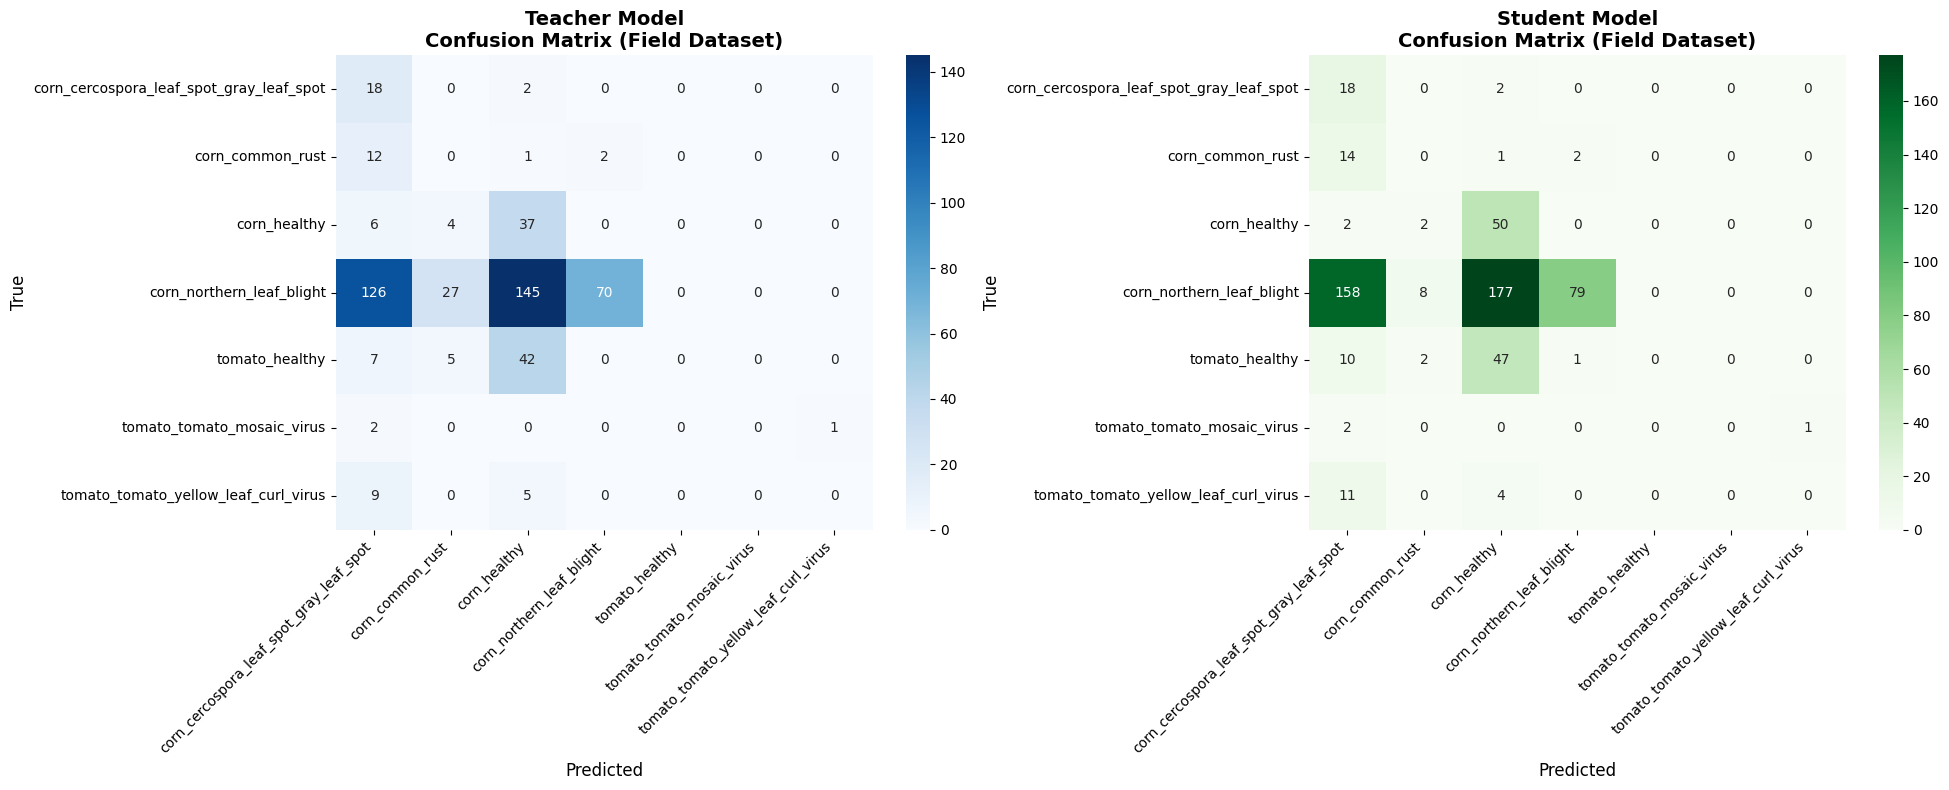

In [16]:
# Create confusion matrices for field dataset (intersection classes only)
intersection_class_ids = sorted([label_to_id[cls] for cls in intersection_classes])
intersection_class_names = [id_to_label[cid] for cid in intersection_class_ids]

cm_teacher = results_teacher_field['confusion_matrix']
cm_student = results_student_field['confusion_matrix']

# Extract only intersection classes
cm_teacher_filtered = cm_teacher[np.ix_(intersection_class_ids, intersection_class_ids)]
cm_student_filtered = cm_student[np.ix_(intersection_class_ids, intersection_class_ids)]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Teacher confusion matrix
sns.heatmap(
    cm_teacher_filtered,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=intersection_class_names,
    yticklabels=intersection_class_names,
    ax=axes[0]
)
axes[0].set_title('Teacher Model\nConfusion Matrix (Field Dataset)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[0].get_yticklabels(), rotation=0)

# Student confusion matrix
sns.heatmap(
    cm_student_filtered,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=intersection_class_names,
    yticklabels=intersection_class_names,
    ax=axes[1]
)
axes[1].set_title('Student Model\nConfusion Matrix (Field Dataset)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
cm_save_path = EXPERIMENT_DIR / "confusion_matrices_field_dataset.png"
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved confusion matrices to: {cm_save_path}")
plt.show()


## Step 5 (continued): Confidence Histogram (Optional)


✓ Saved confidence histogram to: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_4\confidence_histogram.png


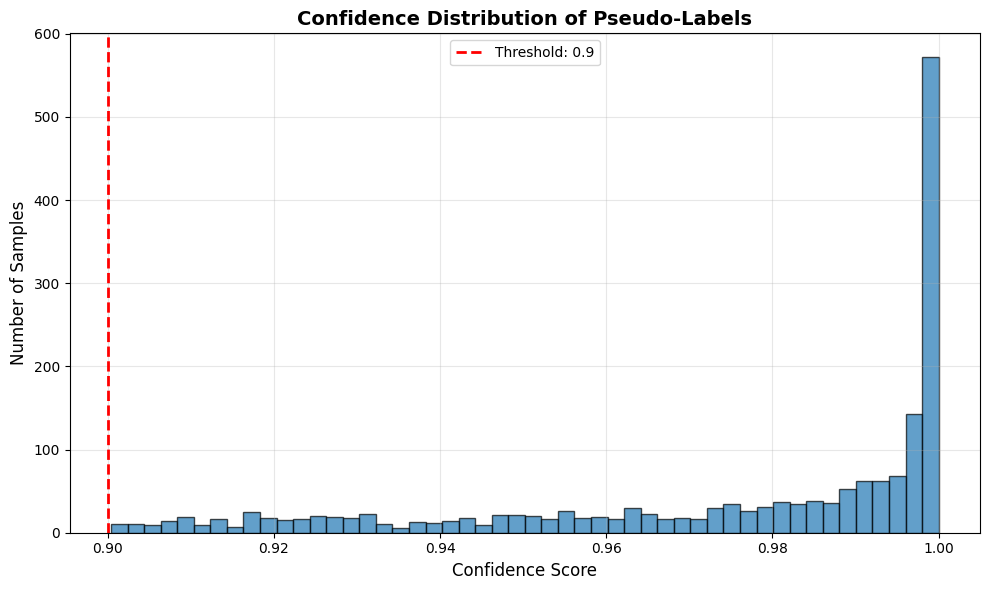


Confidence Statistics:
  Mean: 0.9758
  Median: 0.9897
  Min: 0.9004
  Max: 1.0000
  Std: 0.0288


In [17]:
# Plot confidence histogram of pseudo-labels
confidences = [pl["confidence"] for pl in high_confidence_pseudo_labels]

plt.figure(figsize=(10, 6))
plt.hist(confidences, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=CONFIDENCE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {CONFIDENCE_THRESHOLD}')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Distribution of Pseudo-Labels', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

hist_save_path = EXPERIMENT_DIR / "confidence_histogram.png"
plt.savefig(hist_save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved confidence histogram to: {hist_save_path}")
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Mean: {np.mean(confidences):.4f}")
print(f"  Median: {np.median(confidences):.4f}")
print(f"  Min: {np.min(confidences):.4f}")
print(f"  Max: {np.max(confidences):.4f}")
print(f"  Std: {np.std(confidences):.4f}")


## Step 5 (continued): Generate Report


In [18]:
# Generate comprehensive report
report_path = EXPERIMENT_DIR / "report.txt"

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("EXPERIMENT 4: TEACHER-STUDENT PSEUDO-LABELING REPORT\n")
    f.write("="*70 + "\n\n")
    
    f.write("1. PSEUDO-LABELING STATISTICS\n")
    f.write("-" * 70 + "\n")
    f.write(f"Confidence threshold used: {CONFIDENCE_THRESHOLD}\n")
    f.write(f"Total unlabeled field images: {len(unlabeled_entries_field)}\n")
    f.write(f"High-confidence pseudo-labels kept: {len(high_confidence_pseudo_labels)}\n")
    f.write(f"Retention rate: {len(high_confidence_pseudo_labels)/len(unlabeled_entries_field)*100:.2f}%\n\n")
    
    f.write("Pseudo-labels per class:\n")
    for class_id, count in sorted(pseudo_class_counts.items()):
        class_name = id_to_label[class_id]
        f.write(f"  {class_name}: {count}\n")
    f.write("\n")
    
    f.write("2. TRAINING CONFIGURATION\n")
    f.write("-" * 70 + "\n")
    f.write(f"Teacher model: Baseline augmentation on PlantVillage only\n")
    f.write(f"Student model: Initialized from teacher, trained on combined dataset\n")
    f.write(f"Training ratio: 70% PV / 30% pseudo-field\n")
    f.write(f"Student learning rate: 1e-4 (lower than teacher's 3e-4)\n")
    f.write(f"Student max epochs: 15\n\n")
    
    f.write("3. EVALUATION RESULTS\n")
    f.write("-" * 70 + "\n")
    f.write("\nA) PlantVillage Test Set (All Classes):\n")
    f.write(f"  Teacher - Accuracy: {results_teacher_pv['accuracy']:.4f}, Macro F1: {results_teacher_pv['f1_macro']:.4f}\n")
    f.write(f"  Student - Accuracy: {results_student_pv['accuracy']:.4f}, Macro F1: {results_student_pv['f1_macro']:.4f}\n")
    f.write(f"  Change   - Accuracy: {pv_acc_change:+.4f}, Macro F1: {pv_f1_change:+.4f}\n\n")
    
    f.write("B) Field Test Set (Intersection Classes Only):\n")
    f.write(f"  Teacher - Accuracy: {results_teacher_field['accuracy']:.4f}, Macro F1: {results_teacher_field['f1_macro']:.4f}\n")
    f.write(f"  Student - Accuracy: {results_student_field['accuracy']:.4f}, Macro F1: {results_student_field['f1_macro']:.4f}\n")
    f.write(f"  Change   - Accuracy: {field_acc_change:+.4f}, Macro F1: {field_f1_change:+.4f}\n\n")
    
    f.write("Per-Class F1 Scores (Field Test Set):\n")
    for class_id in intersection_class_ids:
        class_name = id_to_label[class_id]
        teacher_f1 = results_teacher_field['per_class_f1'].get(class_name, 0.0)
        student_f1 = results_student_field['per_class_f1'].get(class_name, 0.0)
        improvement = student_f1 - teacher_f1
        f.write(f"  {class_name:50s}: Teacher={teacher_f1:.4f}, Student={student_f1:.4f}, Change={improvement:+.4f}\n")
    f.write("\n")
    
    f.write("4. SUCCESS CRITERION\n")
    f.write("-" * 70 + "\n")
    if field_f1_change > 0 and abs(pv_f1_change) < 0.05:
        f.write("✓ SUCCESS: Student improves Field macro-F1 without catastrophic PV collapse\n")
        f.write(f"  Field F1 improvement: {field_f1_change:+.4f}\n")
        f.write(f"  PV F1 change: {pv_f1_change:+.4f} (acceptable)\n")
    elif field_f1_change > 0:
        f.write("⚠ PARTIAL SUCCESS: Student improves Field macro-F1 but PV performance degraded\n")
        f.write(f"  Field F1 improvement: {field_f1_change:+.4f}\n")
        f.write(f"  PV F1 change: {pv_f1_change:+.4f} (degradation)\n")
    else:
        f.write("✗ FAILURE: Student does not improve Field macro-F1\n")
        f.write(f"  Field F1 change: {field_f1_change:+.4f}\n")
    f.write("\n")
    
    f.write("5. FILES GENERATED\n")
    f.write("-" * 70 + "\n")
    f.write(f"  - teacher_model.pt: {teacher_checkpoint_path}\n")
    f.write(f"  - student_model.pt: {student_checkpoint_path}\n")
    f.write(f"  - pseudo_labeled_field.csv: {pseudo_label_csv_path}\n")
    f.write(f"  - confusion_matrices_field_dataset.png: {cm_save_path}\n")
    f.write(f"  - confidence_histogram.png: {hist_save_path}\n")
    f.write(f"  - report.txt: {report_path}\n")

print(f"\n✓ Report saved to: {report_path}")

# Print summary
print("\n" + "="*70)
print("EXPERIMENT 4 SUMMARY")
print("="*70)
print(f"\nPseudo-labeling:")
print(f"  Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"  Pseudo-labeled samples: {len(high_confidence_pseudo_labels)}")
print(f"\nResults:")
print(f"  Field F1 improvement: {field_f1_change:+.4f}")
print(f"  PV F1 change: {pv_f1_change:+.4f}")
if field_f1_change > 0 and abs(pv_f1_change) < 0.05:
    print(f"\n✓ SUCCESS: Student improves Field performance without PV collapse")
else:
    print(f"\n⚠ Review results in report.txt for detailed analysis")
print("="*70)



✓ Report saved to: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_4\report.txt

EXPERIMENT 4 SUMMARY

Pseudo-labeling:
  Confidence threshold: 0.9
  Pseudo-labeled samples: 1819

Results:
  Field F1 improvement: +0.0035
  PV F1 change: +0.0015

✓ SUCCESS: Student improves Field performance without PV collapse
